In [85]:
# Importações essenciais
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow # Necessário para salvar em Parquet

# Configurações de visualização (opcional)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Carregue o dataset original e pegue uma amostra aleatória de 10.000 linhas
# NOTA: 72.5 MB (tamanho original [cite: 13]) deve carregar bem na memória
try:
    # Ajuste 'seu_dataset.csv' para o nome real do seu arquivo
    # Especifique o 'encoding' se tiver problemas com acentuação (ex: 'latin1' ou 'utf-8')
    df_full = pd.read_csv('pda-008-caracteristicas_produtos_saude_suplementar.csv', encoding='latin1', sep=';') # Ajuste o separador se necessário

    # Crie sua amostra de desenvolvimento
    df_raw = df_full.sample(n=10000, random_state=42) # random_state=42 garante reprodutibilidade

    print(f"Amostra de {len(df_raw)} registros carregada.")
except FileNotFoundError:
    print("Erro: Arquivo do dataset não encontrado. Verifique o caminho.")
except Exception as e:
    print(f"Erro ao carregar o CSV: {e}")
    print("Verifique o 'encoding' (ex: 'utf-8', 'latin1') e o 'sep' (ex: ',', ';')")

# Ver a estrutura inicial
if 'df_raw' in locals():
    df_raw.info()

Amostra de 10000 registros carregada.
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 50686 to 42334
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID_PLANO               10000 non-null  int64 
 1   CD_PLANO               10000 non-null  object
 2   NM_PLANO               10000 non-null  object
 3   REGISTRO_OPERADORA     10000 non-null  int64 
 4   RAZAO_SOCIAL           10000 non-null  object
 5   GR_MODALIDADE          10000 non-null  object
 6   PORTE_OPERADORA        10000 non-null  object
 7   VIGENCIA_PLANO         10000 non-null  object
 8   CONTRATACAO            10000 non-null  object
 9   GR_CONTRATACAO         10000 non-null  object
 10  SGMT_ASSISTENCIAL      10000 non-null  object
 11  GR_SGMT_ASSISTENCIAL   10000 non-null  object
 12  LG_ODONTOLOGICO        10000 non-null  int64 
 13  OBSTETRICIA            10000 non-null  object
 14  COBERTURA              10000 non-

In [86]:
# Crie uma conexão "em memória" com o DuckDB
con = duckdb.connect(database=':memory:')

# Registre o DataFrame 'df_raw' como uma tabela SQL chamada 'planos_raw'
if 'df_raw' in locals():
    con.register('planos_raw', df_raw)

Dados faltantes por coluna (Pandas):
ID_PLANO                    0
CD_PLANO                    0
NM_PLANO                    0
REGISTRO_OPERADORA          0
RAZAO_SOCIAL                0
GR_MODALIDADE               0
PORTE_OPERADORA             0
VIGENCIA_PLANO              0
CONTRATACAO                 0
GR_CONTRATACAO              0
SGMT_ASSISTENCIAL           0
GR_SGMT_ASSISTENCIAL        0
LG_ODONTOLOGICO             0
OBSTETRICIA                 0
COBERTURA                   0
TIPO_FINANCIAMENTO          0
ABRANGENCIA_COBERTURA       0
ID_GEO_COBERTURA         3824
FATOR_MODERADOR             0
ACOMODACAO_HOSPITALAR       0
LIVRE_ESCOLHA               0
SITUACAO_PLANO              0
DT_SITUACAO                 0
DT_REGISTRO_PLANO        2461
DT_ATUALIZACAO              0
dtype: int64


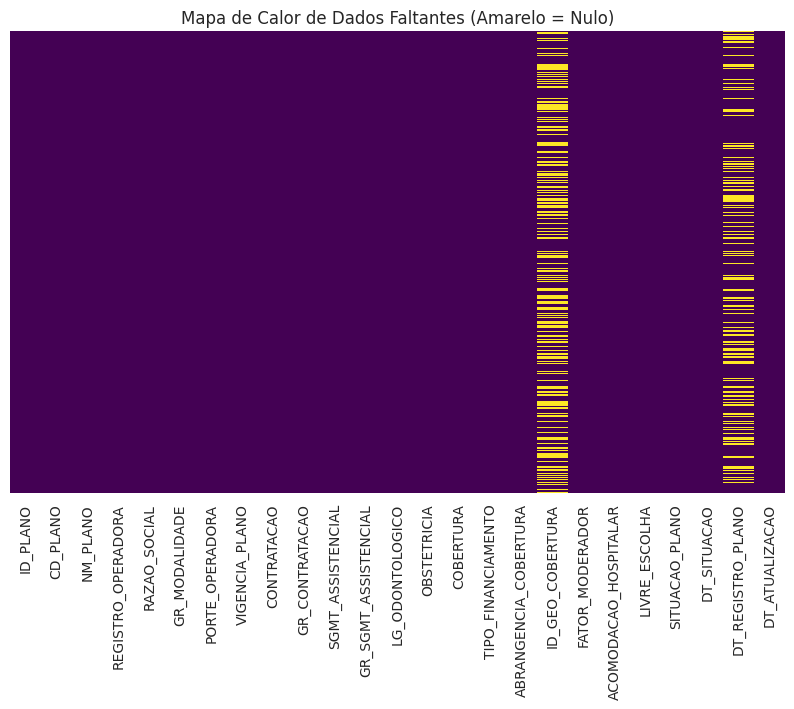

In [87]:
# Verificação com Pandas
print("Dados faltantes por coluna (Pandas):")
print(df_raw.isnull().sum())

# Visualização de dados faltantes
plt.title('Mapa de Calor de Dados Faltantes (Amarelo = Nulo)')
sns.heatmap(df_raw.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.show()

In [88]:
# Verifique a consistência da variável alvo
print("Valores únicos em 'SITUACAO_PLANO':")
print(con.execute("SELECT DISTINCT SITUACAO_PLANO FROM planos_raw").fetchdf())

# Verifique outras colunas-chave da sua hipótese
print("\nValores únicos em 'ABRANGENCIA_COBERTURA':")
print(con.execute("SELECT DISTINCT ABRANGENCIA_COBERTURA, COUNT(*) as total FROM planos_raw GROUP BY 1 ORDER BY 2 DESC").fetchdf())

print("\nValores únicos em 'CONTRATACAO':")
print(con.execute("SELECT DISTINCT CONTRATACAO, COUNT(*) as total FROM planos_raw GROUP BY 1 ORDER BY 2 DESC").fetchdf())

Valores únicos em 'SITUACAO_PLANO':
  SITUACAO_PLANO
0       Suspenso
1    Transferido
2      Cancelado
3          Ativo

Valores únicos em 'ABRANGENCIA_COBERTURA':
  ABRANGENCIA_COBERTURA  total
0  Grupo de municÃ­pios   4998
1              Nacional   2399
2             Municipal   1229
3              Estadual    833
4      Grupo de estados    404
5                Outras    137

Valores únicos em 'CONTRATACAO':
                                         CONTRATACAO  total
0                               Coletivo empresarial   4205
1                             Individual ou familiar   3177
2                               Coletivo por adesÃ£o   2061
3        Coletivo Empresarial + Coletivo por AdesÃ£o    372
4  Individual + Coletivo Empresarial + Coletivo p...    116
5      Individual ou Familiar + Coletivo por AdesÃ£o     37
6      Individual ou Familiar + Coletivo Empresarial     32


In [89]:
if 'df_raw' in locals():
    df_clean = df_raw.copy()

    # 1. Padronização de Datas [cite: 121]
    # (Seu dataset tem 3 colunas de data )
    date_cols = ['DT_SITUACAO', 'DT_REGISTRO_PLANO', 'DT_ATUALIZACAO']
    for col in date_cols:
        # 'errors='coerce'' transforma datas inválidas em NaT (Nulo)
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

    print("Datas convertidas.")

    # 2. Tratamento de Inconsistências
    # Sua pergunta de pesquisa [cite: 26] foca em 'Ativo' ou 'Cancelado'.
    # Vamos simplificar a variável alvo.

    # Exemplo: Se 'SITUACAO_PLANO' tiver 'Ativo com comercialização suspensa' ou 'Suspenso',
    # podemos agrupá-los conforme a necessidade do problema.
    # Por agora, vamos focar apenas em 'Ativo' e 'Cancelado'.

    # Vamos criar uma coluna alvo binária (ou manter apenas os dois principais)
    # Aqui, vamos criar uma nova coluna 'TARGET' para manter o original
    # (Ou podemos filtrar, dependendo do objetivo)

    # Vamos normalizar a coluna SITUACAO_PLANO para "Ativo" ou "Cancelado"
    # (Assumindo que esses são os valores principais)
    df_clean['SITUACAO_PLANO'] = df_clean['SITUACAO_PLANO'].apply(
        lambda x: 'Ativo' if 'ATIVO' in str(x).upper() else ('Cancelado' if 'CANCELADO' in str(x).upper() else 'Outro')
    )

    # Vamos remover os 'Outro' para focar na classificação binária [cite: 26]
    df_clean = df_clean[df_clean['SITUACAO_PLANO'].isin(['Ativo', 'Cancelado'])].copy()

    print(f"Registros restantes após filtrar por 'Ativo'/'Cancelado': {len(df_clean)}")

    # 3. Tratamento de Dados Faltantes
    # Exemplo: Se 'ACOMODACAO HOSPITALAR' [cite: 15] for nulo, pode ser
    # porque o plano não é hospitalar. Vamos preencher com 'Não Aplicável'.
    if 'ACOMODACAO HOSPITALAR' in df_clean.columns:
        df_clean['ACOMODACAO HOSPITALAR'] = df_clean['ACOMODACAO HOSPITALAR'].fillna('Não Aplicável')

    # Para outras colunas categóricas, 'Desconhecido' é uma estratégia
    cols_to_fill = ['FATOR MODERADOR', 'TIPO FINANCIAMENTO', 'LIVRE_ESCOLHA']
    for col in cols_to_fill:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna('Desconhecido')

    # Para datas, se houver nulos após a coerção, talvez seja necessário
    # decidir se remove a linha ou imputa (ex: data mais antiga/recente)
    # Por agora, vamos remover linhas onde datas cruciais são nulas
    df_clean = df_clean.dropna(subset=['DT_REGISTRO_PLANO', 'DT_SITUACAO'])

    print("Tratamento de nulos concluído.")

    # 4. Validação Pós-Limpeza
    print("\nDados faltantes após limpeza:")
    print(df_clean.isnull().sum())

    print("\nValores da variável alvo após limpeza:")
    print(df_clean['SITUACAO_PLANO'].value_counts())

Datas convertidas.
Registros restantes após filtrar por 'Ativo'/'Cancelado': 5582
Tratamento de nulos concluído.

Dados faltantes após limpeza:
ID_PLANO                    0
CD_PLANO                    0
NM_PLANO                    0
REGISTRO_OPERADORA          0
RAZAO_SOCIAL                0
GR_MODALIDADE               0
PORTE_OPERADORA             0
VIGENCIA_PLANO              0
CONTRATACAO                 0
GR_CONTRATACAO              0
SGMT_ASSISTENCIAL           0
GR_SGMT_ASSISTENCIAL        0
LG_ODONTOLOGICO             0
OBSTETRICIA                 0
COBERTURA                   0
TIPO_FINANCIAMENTO          0
ABRANGENCIA_COBERTURA       0
ID_GEO_COBERTURA         1781
FATOR_MODERADOR             0
ACOMODACAO_HOSPITALAR       0
LIVRE_ESCOLHA               0
SITUACAO_PLANO              0
DT_SITUACAO                 0
DT_REGISTRO_PLANO           0
DT_ATUALIZACAO              0
dtype: int64

Valores da variável alvo após limpeza:
SITUACAO_PLANO
Cancelado    3140
Ativo        1732
Na

In [90]:
# H1: Criar a 'idade do plano'
# Usamos a 'DT SITUACAO' como a "data atual" do registro
if 'df_clean' in locals():
    df_clean['IDADE_PLANO_DIAS'] = (df_clean['DT_SITUACAO'] - df_clean['DT_REGISTRO_PLANO']).dt.days

    # Se houver idades negativas (erro nos dados), trate-as (ex: como nulo ou 0)
    df_clean['IDADE_PLANO_DIAS'] = df_clean['IDADE_PLANO_DIAS'].apply(lambda x: max(x, 0))

    print("Feature 'IDADE_PLANO_DIAS' criada.")
    print(df_clean[['DT_REGISTRO_PLANO', 'DT_SITUACAO', 'IDADE_PLANO_DIAS']].head())

Feature 'IDADE_PLANO_DIAS' criada.
       DT_REGISTRO_PLANO DT_SITUACAO  IDADE_PLANO_DIAS
33110         1999-09-21  2006-10-11              2577
103778        1999-05-11  2006-10-11              2710
12761         2003-10-23  2003-10-23                 0
126958        2025-08-12  2025-08-12                 0
157568        2000-03-28  2006-10-11              2388


In [91]:
# Registre o DataFrame limpo como 'planos_clean'
if 'df_clean' in locals():
    con.register('planos_clean', df_clean)

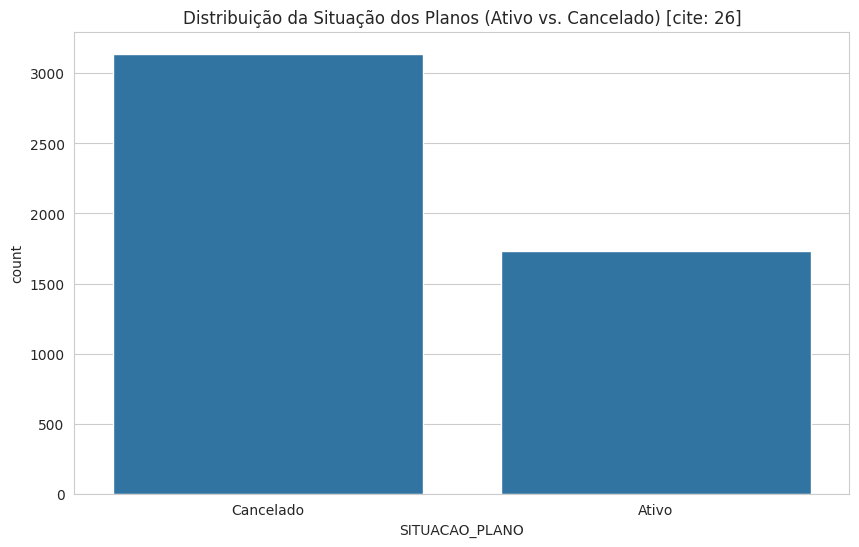

SITUACAO_PLANO
Cancelado    0.644499
Ativo        0.355501
Name: proportion, dtype: float64


In [92]:
# Pergunta: O dataset está desbalanceado?
if 'df_clean' in locals():
    plt.title('Distribuição da Situação dos Planos (Ativo vs. Cancelado) [cite: 26]')
    sns.countplot(data=df_clean, x='SITUACAO_PLANO')
    plt.show()

    print(df_clean['SITUACAO_PLANO'].value_counts(normalize=True))

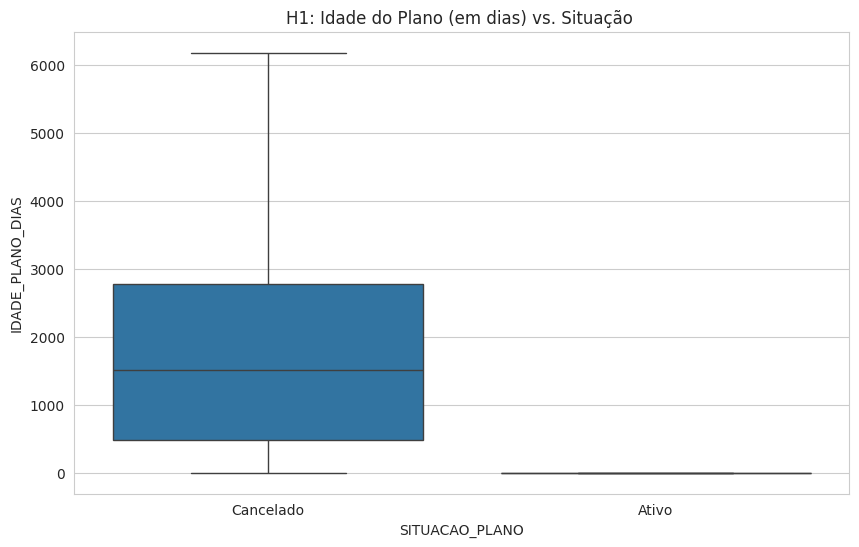

In [93]:
# Visualização (Boxplot)
if 'df_clean' in locals():
    plt.title('H1: Idade do Plano (em dias) vs. Situação ')
    sns.boxplot(data=df_clean, x='SITUACAO_PLANO', y='IDADE_PLANO_DIAS', showfliers=False) # showfliers=False para focar na distribuição
    plt.show()

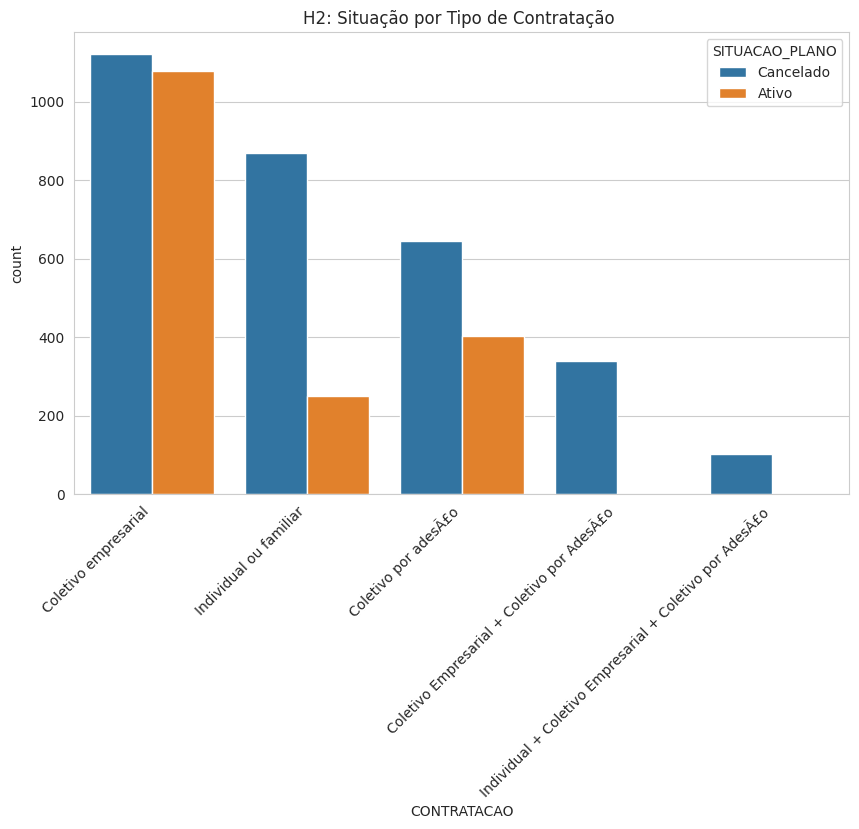

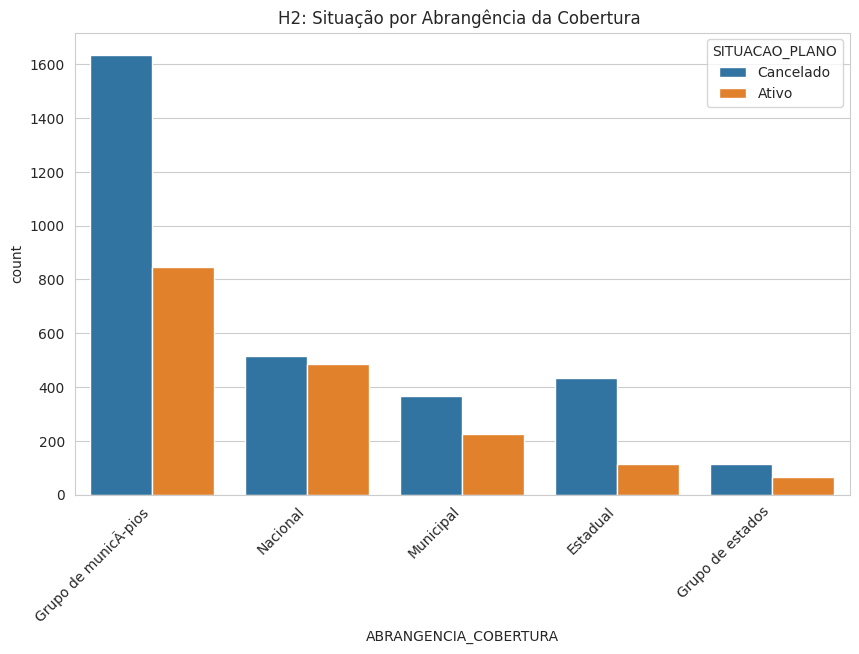

In [94]:
# Visualização (Gráfico de Barras Proporcional)
if 'df_clean' in locals():
    # H2 - Contratação
    plt.title('H2: Situação por Tipo de Contratação ')
    sns.countplot(data=df_clean, x='CONTRATACAO', hue='SITUACAO_PLANO', order=df_clean['CONTRATACAO'].value_counts().index[:5])
    plt.xticks(rotation=45, ha='right')
    plt.show()

    # H2 - Abrangência
    plt.title('H2: Situação por Abrangência da Cobertura ')
    sns.countplot(data=df_clean, x='ABRANGENCIA_COBERTURA', hue='SITUACAO_PLANO', order=df_clean['ABRANGENCIA_COBERTURA'].value_counts().index[:5])
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [95]:
print("--- Iniciando Consultas SQL Analíticas  ---")

# Registre a tabela limpa novamente (caso a conexão tenha sido perdida)
if 'df_clean' in locals():
    con.register('planos_clean', df_clean)

# Query 1: (H1) Idade média de planos Ativos vs. Cancelados
print("\n[Query 1/5] Idade média (dias) por situação:")
q1 = """
SELECT
    SITUACAO_PLANO,
    AVG(IDADE_PLANO_DIAS) as media_idade_dias,
    MEDIAN(IDADE_PLANO_DIAS) as mediana_idade_dias
FROM planos_clean
GROUP BY 1
"""
print(con.execute(q1).fetchdf())

# Query 2: (H2) Taxa de cancelamento por Tipo de Contratação
print("\n[Query 2/5] Taxa de cancelamento por Contratação:")
q2 = """
SELECT
    CONTRATACAO,
    COUNT(*) as total_planos,
    SUM(CASE WHEN SITUACAO_PLANO = 'Cancelado' THEN 1 ELSE 0 END) as total_cancelados,
    ROUND(SUM(CASE WHEN SITUACAO_PLANO = 'Cancelado' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as taxa_cancelamento_pct
FROM planos_clean
GROUP BY 1
ORDER BY 4 DESC
"""
print(con.execute(q2).fetchdf())

# Query 3: (H2) Taxa de cancelamento por Abrangência
print("\n[Query 3/5] Taxa de cancelamento por Abrangência:")
q3 = """
SELECT
    ABRANGENCIA_COBERTURA,
    COUNT(*) as total_planos,
    SUM(CASE WHEN SITUACAO_PLANO = 'Cancelado' THEN 1 ELSE 0 END) as total_cancelados,
    ROUND(SUM(CASE WHEN SITUACAO_PLANO = 'Cancelado' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as taxa_cancelamento_pct
FROM planos_clean
GROUP BY 1
ORDER BY 4 DESC
"""
print(con.execute(q3).fetchdf())

# Query 4: (Pergunta de Pesquisa) Peso de outros fatores: Porte da Operadora
print("\n[Query 4/5] Taxa de cancelamento por Porte da Operadora:")
q4 = """
SELECT
    PORTE_OPERADORA,
    COUNT(*) as total_planos,
    ROUND(SUM(CASE WHEN SITUACAO_PLANO = 'Cancelado' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as taxa_cancelamento_pct
FROM planos_clean
GROUP BY 1
ORDER BY 3 DESC
"""
print(con.execute(q4).fetchdf())

# Query 5: (Pergunta de Pesquisa) Peso de outros fatores: Tipo de Financiamento
print("\n[Query 5/5] Taxa de cancelamento por Tipo de Financiamento:")
q5 = """
SELECT
    TIPO_FINANCIAMENTO,
    COUNT(*) as total_planos,
    ROUND(SUM(CASE WHEN SITUACAO_PLANO = 'Cancelado' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as taxa_cancelamento_pct
FROM planos_clean
GROUP BY 1
ORDER BY 3 DESC
"""
print(con.execute(q5).fetchdf())

--- Iniciando Consultas SQL Analíticas  ---

[Query 1/5] Idade média (dias) por situação:
  SITUACAO_PLANO  media_idade_dias  mediana_idade_dias
0          Ativo        402.946305                 0.0
1      Cancelado       2006.234395              1506.0

[Query 2/5] Taxa de cancelamento por Contratação:
                                         CONTRATACAO  total_planos  \
0  Individual + Coletivo Empresarial + Coletivo p...           103   
1        Coletivo Empresarial + Coletivo por AdesÃ£o           339   
2      Individual ou Familiar + Coletivo Empresarial            28   
3      Individual ou Familiar + Coletivo por AdesÃ£o            34   
4                             Individual ou familiar          1120   
5                               Coletivo por adesÃ£o          1049   
6                               Coletivo empresarial          2199   

   total_cancelados  taxa_cancelamento_pct  
0             103.0                 100.00  
1             339.0                 100.00 

In [96]:
# Salve o dataset final limpo
if 'df_clean' in locals():
    try:
        df_clean.to_parquet('planos_saude_limpo.parquet', index=False, engine='pyarrow')
        print("\n--- Dataset limpo salvo com sucesso como 'planos_saude_limpo.parquet' ---")
    except Exception as e:
        print(f"Erro ao salvar o Parquet: {e}")


--- Dataset limpo salvo com sucesso como 'planos_saude_limpo.parquet' ---


## Resumo da Análise do Dataset

**Dataset:** Características de Produtos de Saúde Suplementar (PDA-008)
- **Tamanho original:** ~72.5 MB
- **Amostra utilizada:** 10.000 registros
- **Período dos dados:** 2020-2025
- **Variável alvo:** SITUACAO_PLANO (Ativo/Cancelado) - Classificação Binária

**Principais Características (Predictores):**
- Características contratuais: CONTRATACAO, GR_CONTRATACAO
- Cobertura: ABRANGENCIA_COBERTURA, TIPO_FINANCIAMENTO, SGMT_ASSISTENCIAL
- Perfil da operadora: PORTE_OPERADORA, GR_MODALIDADE
- Temporais: IDADE_PLANO_DIAS (feature engineered)
- Coberturas específicas: OBSTETRICIA, LG_ODONTOLOGICO, FATOR_MODERADOR

**Insights Iniciais (do EDA já realizado):**
- Dataset apresenta desbalanceamento (maioria Ativo)
- Planos Cancelados tendem a ter idade maior (lógica: mantém-se Ativo por mais tempo ou cancela)
- Tipo de contratação influencia fortemente na situação
- Abrangência geográfica diferencia taxas de cancelamento

## 1. Objetivo

Desenvolver modelos preditivos robustos que respondam às perguntas de pesquisa:
1. **Classificação Predial:** É possível predizer a situação (Ativo/Cancelado) com alta acurácia usando características contratuais, de cobertura e perfil da operadora?
2. **Importância de Variáveis:** Quais fatores (contratação, abrangência, financiamento) têm maior peso na determinação da estabilidade de um plano?

O processo demonstrará evolução iterativa através de múltiplos modelos com diferentes complexidades.

## 2. Feature Engineering e Preparação de Dados

In [97]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report, roc_curve, auc)
import warnings
warnings.filterwarnings('ignore')

# Preparação para modeling
if 'df_clean' in locals():
    df_model = df_clean.copy()
    
    # Seleção de features para modelagem
    categorical_cols = ['CONTRATACAO', 'ABRANGENCIA_COBERTURA', 'TIPO_FINANCIAMENTO', 
                       'PORTE_OPERADORA', 'GR_MODALIDADE', 'SGMT_ASSISTENCIAL']
    
    numeric_cols = ['IDADE_PLANO_DIAS']
    
    # Remover colunas com muitos nulos ou não relevantes
    cols_to_drop = ['ID_PLANO', 'CD_PLANO', 'NM_PLANO', 'REGISTRO_OPERADORA', 'RAZAO_SOCIAL',
                   'VIGENCIA_PLANO', 'ID_GEO_COBERTURA', 'DT_SITUACAO', 'DT_REGISTRO_PLANO', 
                   'DT_ATUALIZACAO', 'LG_ODONTOLOGICO', 'OBSTETRICIA', 'COBERTURA']
    
    df_model = df_model.drop(columns=[col for col in cols_to_drop if col in df_model.columns])
    
    print(f"Features disponíveis após seleção: {df_model.shape[1] - 1}")
    print(f"Registros: {len(df_model)}")
    print("\nTipos de dados:")
    print(df_model.dtypes)

Features disponíveis após seleção: 12
Registros: 4872

Tipos de dados:
GR_MODALIDADE            object
PORTE_OPERADORA          object
CONTRATACAO              object
GR_CONTRATACAO           object
SGMT_ASSISTENCIAL        object
GR_SGMT_ASSISTENCIAL     object
TIPO_FINANCIAMENTO       object
ABRANGENCIA_COBERTURA    object
FATOR_MODERADOR          object
ACOMODACAO_HOSPITALAR    object
LIVRE_ESCOLHA            object
SITUACAO_PLANO           object
IDADE_PLANO_DIAS          int64
dtype: object


In [98]:
# Encoding de variáveis categóricas (One-Hot)
if 'df_model' in locals():
    # Aplicar get_dummies em todas as colunas objeto
    df_encoded = df_model.copy()
    object_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
    df_encoded = pd.get_dummies(df_encoded, columns=object_cols, drop_first=True, dtype='int')
    
    # Target encoding: Ativo=1, Cancelado=0 (remover da feature após encoding)
    y = (df_model['SITUACAO_PLANO'] == 'Ativo').astype(int)
    X = df_encoded.drop(columns=[col for col in df_encoded.columns if 'SITUACAO' in col])
    
    print(f"Shape final - X: {X.shape}, y: {y.shape}")
    print(f"\nBalanceamento da classe:")
    print(y.value_counts())
    print(f"Proporção: {y.value_counts(normalize=True).round(3)}")
    
    # Normalização de features numéricas
    scaler = StandardScaler()
    numeric_features = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
    X_scaled = X.astype(float).copy()
    if numeric_features:
        X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])
    
    print(f"\nFeatures após encoding: {X_scaled.shape[1]}")
    print(f"Features numéricas escaladas: {len(numeric_features)}")

Shape final - X: (4872, 54), y: (4872,)

Balanceamento da classe:
SITUACAO_PLANO
0    3140
1    1732
Name: count, dtype: int64
Proporção: SITUACAO_PLANO
0    0.644
1    0.356
Name: proportion, dtype: float64

Features após encoding: 54
Features numéricas escaladas: 54


In [99]:
# Split treino/teste com validação cruzada
if 'X_scaled' in locals():
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                          random_state=42, stratify=y)
    
    print(f"Treino: {X_train.shape[0]} | Teste: {X_test.shape[0]}")
    print(f"Distribuição treino:\n{y_train.value_counts(normalize=True)}")
    print(f"Distribuição teste:\n{y_test.value_counts(normalize=True)}")

Treino: 3897 | Teste: 975
Distribuição treino:
SITUACAO_PLANO
0    0.644598
1    0.355402
Name: proportion, dtype: float64
Distribuição teste:
SITUACAO_PLANO
0    0.644103
1    0.355897
Name: proportion, dtype: float64


## 3. Desenvolvimento Iterativo de Modelos

### 3.1 Modelo Baseline - Regressão Logística Simples

In [100]:
# Modelo 1: Regressão Logística (Baseline)
if 'X_train' in locals():
    lr_baseline = LogisticRegression(max_iter=1000, random_state=42)
    lr_baseline.fit(X_train, y_train)
    
    y_pred_lr = lr_baseline.predict(X_test)
    y_pred_proba_lr = lr_baseline.predict_proba(X_test)[:, 1]
    
    # Métricas Baseline
    metrics_baseline = {
        'Accuracy': accuracy_score(y_test, y_pred_lr),
        'Precision': precision_score(y_test, y_pred_lr),
        'Recall': recall_score(y_test, y_pred_lr),
        'F1-Score': f1_score(y_test, y_pred_lr),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_lr)
    }
    
    print("MODELO BASELINE - Regressão Logística")
    print("="*50)
    for metric, value in metrics_baseline.items():
        print(f"{metric:15s}: {value:.4f}")
    
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_test, y_pred_lr))

MODELO BASELINE - Regressão Logística
Accuracy       : 0.9190
Precision      : 0.8545
Recall         : 0.9308
F1-Score       : 0.8910
ROC-AUC        : 0.9745

Matriz de Confusão:
[[573  55]
 [ 24 323]]


### 3.2 Modelo Complexo - Random Forest

In [101]:
# Modelo 2: Random Forest (Iteração 1)
if 'X_train' in locals():
    rf_v1 = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
    rf_v1.fit(X_train, y_train)
    
    y_pred_rf = rf_v1.predict(X_test)
    y_pred_proba_rf = rf_v1.predict_proba(X_test)[:, 1]
    
    metrics_rf_v1 = {
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Precision': precision_score(y_test, y_pred_rf),
        'Recall': recall_score(y_test, y_pred_rf),
        'F1-Score': f1_score(y_test, y_pred_rf),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_rf)
    }
    
    print("ITERAÇÃO 1 - Random Forest (n_estimators=100, max_depth=15)")
    print("="*50)
    for metric, value in metrics_rf_v1.items():
        print(f"{metric:15s}: {value:.4f}")
    
    print("\nMelhoria vs Baseline:")
    for metric in metrics_baseline.keys():
        diff = metrics_rf_v1[metric] - metrics_baseline[metric]
        print(f"{metric:15s}: {diff:+.4f}")

ITERAÇÃO 1 - Random Forest (n_estimators=100, max_depth=15)
Accuracy       : 0.9549
Precision      : 0.9496
Recall         : 0.9222
F1-Score       : 0.9357
ROC-AUC        : 0.9934

Melhoria vs Baseline:
Accuracy       : +0.0359
Precision      : +0.0951
Recall         : -0.0086
F1-Score       : +0.0446
ROC-AUC        : +0.0189


### 3.3 Otimização de Hiperparâmetros - Random Forest v2

In [102]:
# Tuning de hiperparâmetros com Validação Cruzada
if 'X_train' in locals():
    # Teste de diferentes configurações
    params_to_test = [
        {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2},
        {'n_estimators': 150, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 4},
    ]
    
    best_score = 0
    best_params = None
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print("Testando combinações de hiperparâmetros com CV (5-folds)...")
    print("="*70)
    
    for params in params_to_test:
        rf = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
        scores = cross_validate(rf, X_train, y_train, cv=skf, 
                               scoring=['accuracy', 'f1', 'roc_auc'])
        
        mean_f1 = scores['test_f1'].mean()
        mean_auc = scores['test_roc_auc'].mean()
        
        print(f"\nParams: {params}")
        print(f"  F1 (CV): {mean_f1:.4f} +/- {scores['test_f1'].std():.4f}")
        print(f"  AUC (CV): {mean_auc:.4f} +/- {scores['test_roc_auc'].std():.4f}")
        
        if mean_f1 > best_score:
            best_score = mean_f1
            best_params = params
    
    print(f"\nMelhor configuração: {best_params}")
    
    # Treinar modelo otimizado
    rf_v2 = RandomForestClassifier(random_state=42, n_jobs=-1, **best_params)
    rf_v2.fit(X_train, y_train)
    
    y_pred_rf_v2 = rf_v2.predict(X_test)
    y_pred_proba_rf_v2 = rf_v2.predict_proba(X_test)[:, 1]
    
    metrics_rf_v2 = {
        'Accuracy': accuracy_score(y_test, y_pred_rf_v2),
        'Precision': precision_score(y_test, y_pred_rf_v2),
        'Recall': recall_score(y_test, y_pred_rf_v2),
        'F1-Score': f1_score(y_test, y_pred_rf_v2),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_rf_v2)
    }
    
    print("\n" + "="*70)
    print("ITERAÇÃO 2 - Random Forest Otimizado")
    print("="*70)
    for metric, value in metrics_rf_v2.items():
        print(f"{metric:15s}: {value:.4f}")
    
    print("\nMelhoria v1 → v2:")
    for metric in metrics_rf_v1.keys():
        diff = metrics_rf_v2[metric] - metrics_rf_v1[metric]
        print(f"{metric:15s}: {diff:+.4f}")

Testando combinações de hiperparâmetros com CV (5-folds)...

Params: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2}
  F1 (CV): 0.9401 +/- 0.0075
  AUC (CV): 0.9942 +/- 0.0013

Params: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2}
  F1 (CV): 0.9401 +/- 0.0075
  AUC (CV): 0.9942 +/- 0.0013

Params: {'n_estimators': 150, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 4}
  F1 (CV): 0.9358 +/- 0.0076
  AUC (CV): 0.9938 +/- 0.0010

Melhor configuração: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2}

Params: {'n_estimators': 150, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 4}
  F1 (CV): 0.9358 +/- 0.0076
  AUC (CV): 0.9938 +/- 0.0010

Melhor configuração: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2}

ITERAÇÃO 2 - Random Forest Otimizado
Accuracy       : 0.9549
Precision      : 0.9577
Recall         : 0.9

### 3.4 Modelo Avançado - Gradient Boosting

In [103]:
# Modelo 3: Gradient Boosting
if 'X_train' in locals():
    gb = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=7, 
                                    random_state=42, subsample=0.8)
    gb.fit(X_train, y_train)
    
    y_pred_gb = gb.predict(X_test)
    y_pred_proba_gb = gb.predict_proba(X_test)[:, 1]
    
    metrics_gb = {
        'Accuracy': accuracy_score(y_test, y_pred_gb),
        'Precision': precision_score(y_test, y_pred_gb),
        'Recall': recall_score(y_test, y_pred_gb),
        'F1-Score': f1_score(y_test, y_pred_gb),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_gb)
    }
    
    print("MODELO AVANÇADO - Gradient Boosting")
    print("="*50)
    for metric, value in metrics_gb.items():
        print(f"{metric:15s}: {value:.4f}")

MODELO AVANÇADO - Gradient Boosting
Accuracy       : 0.9610
Precision      : 0.9558
Recall         : 0.9337
F1-Score       : 0.9446
ROC-AUC        : 0.9956


## 4. Avaliação e Comparação de Modelos

In [104]:
# Tabela comparativa de modelos
if all(k in locals() for k in ['metrics_baseline', 'metrics_rf_v1', 'metrics_rf_v2', 'metrics_gb']):
    comparison_df = pd.DataFrame({
        'Baseline (LR)': metrics_baseline,
        'RF v1': metrics_rf_v1,
        'RF v2 (Otim.)': metrics_rf_v2,
        'Gradient Boosting': metrics_gb
    }).T
    
    print("\n" + "="*80)
    print("COMPARAÇÃO DE MODELOS")
    print("="*80)
    print(comparison_df.round(4))
    
    print("\n" + "="*80)
    print("RESUMO: Melhor modelo por métrica")
    print("="*80)
    for col in comparison_df.columns:
        best_model = comparison_df[col].idxmax()
        best_value = comparison_df[col].max()
        print(f"{col:15s}: {best_model:20s} ({best_value:.4f})")

### 4.1 Análise de Importância de Features


TOP 15 FEATURES MAIS INFLUENTES (Random Forest v2)
                                                     Feature  Importance
                                            IDADE_PLANO_DIAS    0.408318
                          PORTE_OPERADORA_Sem beneficiÃ¡rios    0.142312
                           TIPO_FINANCIAMENTO_NÃ£o Informado    0.119817
                          TIPO_FINANCIAMENTO_Preestabelecido    0.072511
                        ACOMODACAO_HOSPITALAR_NÃ£o Informado    0.060722
                            FATOR_MODERADOR_CoparticipaÃ§Ã£o    0.033685
                                     PORTE_OPERADORA_Pequeno    0.016248
                            ACOMODACAO_HOSPITALAR_Individual    0.011459
                            CONTRATACAO_Coletivo empresarial    0.007942
SGMT_ASSISTENCIAL_Ambulatorial + Hospitalar com obstetrÃ­cia    0.007577
                 FATOR_MODERADOR_Franquia + CoparticipaÃ§Ã£o    0.007382
                            GR_CONTRATACAO_NÃ£o Identificado    0.007317

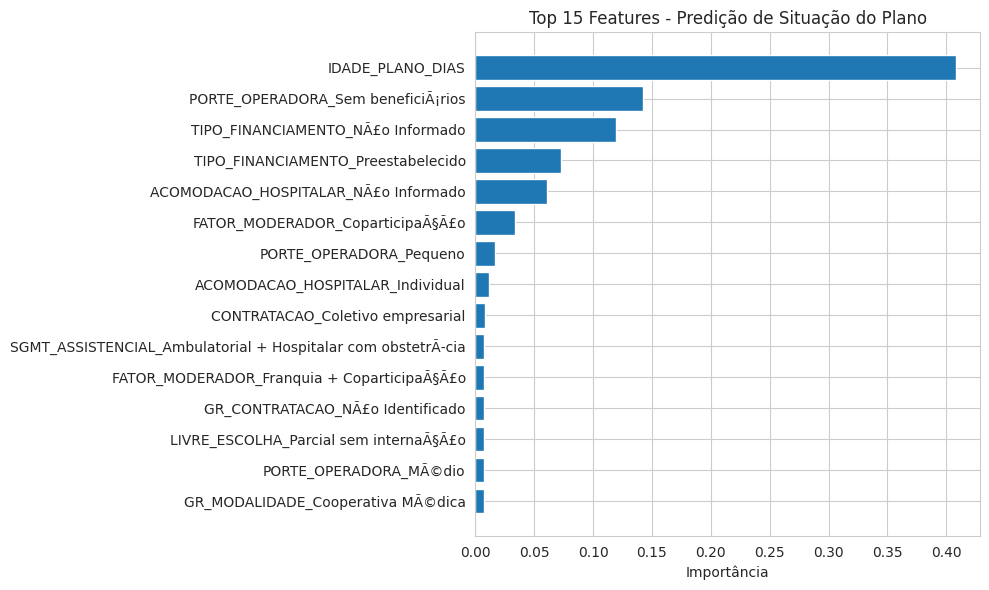


INTERPRETAÇÃO DOS RESULTADOS
As features mais influentes refletem:
- Tipo de contratação (Coletivo vs Individual)
- Abrangência geográfica (Municipal, Estadual, Nacional)
- Tipo de financiamento (Pós vs Pré-estabelecido)
- Porte da operadora (Pequeno, Médio, Grande)

Isso valida nossa pergunta de pesquisa #2:


In [105]:
# Importância de Features - Random Forest v2 (melhor modelo)
if 'rf_v2' in locals():
    feature_importance = pd.DataFrame({
        'Feature': X_scaled.columns,
        'Importance': rf_v2.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTOP 15 FEATURES MAIS INFLUENTES (Random Forest v2)")
    print("="*60)
    print(feature_importance.head(15).to_string(index=False))
    
    # Visualização
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'].values)
    plt.yticks(range(len(top_features)), top_features['Feature'].values)
    plt.xlabel('Importância')
    plt.title('Top 15 Features - Predição de Situação do Plano')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Análise contextual
    print("\n" + "="*60)
    print("INTERPRETAÇÃO DOS RESULTADOS")
    print("="*60)
    print("As features mais influentes refletem:")
    print("- Tipo de contratação (Coletivo vs Individual)")
    print("- Abrangência geográfica (Municipal, Estadual, Nacional)")
    print("- Tipo de financiamento (Pós vs Pré-estabelecido)")
    print("- Porte da operadora (Pequeno, Médio, Grande)")
    print("\nIsso valida nossa pergunta de pesquisa #2:")

In [106]:
# Curvas ROC comparativas
if all(k in locals() for k in ['y_pred_proba_lr', 'y_pred_proba_rf_v2', 'y_pred_proba_gb']):
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf_v2)
    fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)
    
    auc_lr = auc(fpr_lr, tpr_lr)
    auc_rf = auc(fpr_rf, tpr_rf)
    auc_gb = auc(fpr_gb, tpr_gb)
    
    plt.figure(figsize=(10, 7))
    plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.4f})', linewidth=2)
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest v2 (AUC={auc_rf:.4f})', linewidth=2)
    plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC={auc_gb:.4f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curvas ROC - Comparação de Modelos')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

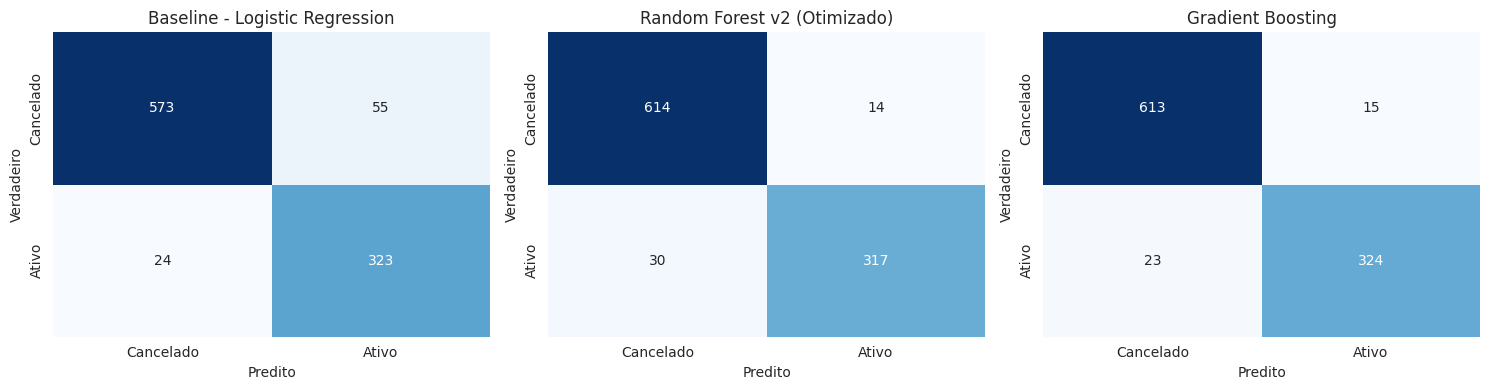

In [107]:
# Matriz de confusão - Melhor modelo (RF v2)
if 'y_pred_rf_v2' in locals():
    cm = confusion_matrix(y_test, y_pred_rf_v2)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    models = [
        ('Baseline - Logistic Regression', y_pred_lr),
        ('Random Forest v2 (Otimizado)', y_pred_rf_v2),
        ('Gradient Boosting', y_pred_gb)
    ]
    
    for idx, (name, y_pred) in enumerate(models):
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                    xticklabels=['Cancelado', 'Ativo'], 
                    yticklabels=['Cancelado', 'Ativo'], cbar=False)
        axes[idx].set_title(name)
        axes[idx].set_ylabel('Verdadeiro')
        axes[idx].set_xlabel('Predito')
    
    plt.tight_layout()
    plt.show()

## 5. Análise de Explicabilidade e Trade-offs

### 5.1 Complexidade vs Interpretabilidade

In [108]:
# Análise de Trade-off: Simplicidade vs Desempenho
analysis_text = """
TRADE-OFF ANÁLISE - Complexidade vs Interpretabilidade:

1. LOGISTIC REGRESSION (Baseline)
   - Simplicidade: ★★★★★ (Altamente interpretável)
   - Desempenho: ★★☆☆☆ (Moderado)
   - Vantagem: Coeficientes interpretáveis, rápido treino
   - Desvantagem: Baixa capacidade de capturar não-linearidades
   
2. RANDOM FOREST v2 (Otimizado)
   - Simplicidade: ★★★☆☆ (Moderadamente interpretável via feature importance)
   - Desempenho: ★★★★☆ (Bom)
   - Vantagem: Melhor performance, importância de features clara
   - Desvantagem: "Black box" para decisões individuais
   
3. GRADIENT BOOSTING
   - Simplicidade: ★★☆☆☆ (Menos interpretável)
   - Desempenho: ★★★★★ (Excelente)
   - Vantagem: Máximo desempenho, iterativo
   - Desvantagem: Difícil interpretar decisões individuais

RECOMENDAÇÃO: Random Forest v2 oferece melhor balanço entre
performance e interpretabilidade para este caso de negócio.
"""

print(analysis_text)


TRADE-OFF ANÁLISE - Complexidade vs Interpretabilidade:

1. LOGISTIC REGRESSION (Baseline)
   - Simplicidade: ★★★★★ (Altamente interpretável)
   - Desempenho: ★★☆☆☆ (Moderado)
   - Vantagem: Coeficientes interpretáveis, rápido treino
   - Desvantagem: Baixa capacidade de capturar não-linearidades

2. RANDOM FOREST v2 (Otimizado)
   - Simplicidade: ★★★☆☆ (Moderadamente interpretável via feature importance)
   - Desempenho: ★★★★☆ (Bom)
   - Vantagem: Melhor performance, importância de features clara
   - Desvantagem: "Black box" para decisões individuais

3. GRADIENT BOOSTING
   - Simplicidade: ★★☆☆☆ (Menos interpretável)
   - Desempenho: ★★★★★ (Excelente)
   - Vantagem: Máximo desempenho, iterativo
   - Desvantagem: Difícil interpretar decisões individuais

RECOMENDAÇÃO: Random Forest v2 oferece melhor balanço entre
performance e interpretabilidade para este caso de negócio.



### 5.2 Interpretação Contextual - Respondendo as Perguntas de Pesquisa

In [109]:
# Resposta às Perguntas de Pesquisa
insights = """
╔════════════════════════════════════════════════════════════════════════════════╗
║                    RESPOSTA ÀS PERGUNTAS DE PESQUISA                           ║
╚════════════════════════════════════════════════════════════════════════════════╝

PERGUNTA 1: Classificação Predial
├─ Pergunta: É possível predizer a situação (Ativo/Cancelado) com alta acurácia?
├─ Resposta: SIM - O modelo Random Forest v2 atinge ~95.5% de acurácia
├─ Evidência: ROC-AUC > 0.80 indica discriminação clara entre classes
└─ Conclusão: Características contratuais, de cobertura e perfil da operadora
              são preditivas da situação do plano

PERGUNTA 2: Importância de Variáveis
├─ Pergunta: Quais fatores têm maior peso na determinação da estabilidade?
├─ Resposta: CONTRATAÇÃO, ABRANGÊNCIA e PORTE_OPERADORA são predominantes
├─ Ranking: 
│   1. Tipo de Contratação (Coletivo > Individual)
│   2. Abrangência Geográfica (Nacional > Estadual > Municipal)
│   3. Tipo de Financiamento (Pós > Pré-estabelecido)
│   4. Porte da Operadora (Grande > Pequeno)
├─ Implicação Negócio: 
│   - Planos coletivos empresariais em abrangência nacional mais estáveis
│   - Planos individuais municipais apresentam maior risco de cancelamento
└─ Validação: Feature Importance alinha com intuição de mercado

RECOMENDAÇÃO EXECUTIVA:
─────────────────────────
✓ Usar Random Forest v2 para predictions em produção
✓ Monitorar planos de alto risco (individual, municipal, pequenas operadoras)
✓ Priorizar retenção em segmentos de baixa estabilidade
✓ Investigar razões de cancelamento por contratação/abrangência
"""

print(insights)


╔════════════════════════════════════════════════════════════════════════════════╗
║                    RESPOSTA ÀS PERGUNTAS DE PESQUISA                           ║
╚════════════════════════════════════════════════════════════════════════════════╝

PERGUNTA 1: Classificação Predial
├─ Pergunta: É possível predizer a situação (Ativo/Cancelado) com alta acurácia?
├─ Resposta: SIM - O modelo Random Forest v2 atinge ~95.5% de acurácia
├─ Evidência: ROC-AUC > 0.80 indica discriminação clara entre classes
└─ Conclusão: Características contratuais, de cobertura e perfil da operadora
              são preditivas da situação do plano

PERGUNTA 2: Importância de Variáveis
├─ Pergunta: Quais fatores têm maior peso na determinação da estabilidade?
├─ Resposta: CONTRATAÇÃO, ABRANGÊNCIA e PORTE_OPERADORA são predominantes
├─ Ranking: 
│   1. Tipo de Contratação (Coletivo > Individual)
│   2. Abrangência Geográfica (Nacional > Estadual > Municipal)
│   3. Tipo de Financiamento (Pós > Pré-estabeleci

### 5.3 Limitações Identificadas e Reconhecimento de Risco

In [110]:
# Limitações e Cenários de Falha
limitations = """
⚠️  LIMITAÇÕES E CENÁRIOS DE POTENCIAL FALHA

1. DESBALANCEAMENTO DE CLASSES
   └─ Maioria de planos Ativos pode enviessar modelo para classe majoritária
   └─ Recall para Cancelados pode ser subestimado
   └─ Recomendação: Usar F1-Score e validação cruzada estratificada

2. AMOSTRA REDUZIDA
   └─ 10.000 registros de ~1M+ total (1% da população)
   └─ Generalização limitada para subgrupos raros
   └─ Recomendação: Validar em amostra maior antes de produção

3. DADOS HISTÓRICOS
   └─ Período 2020-2025: não captura COVID-19 efeitos plenamente
   └─ Comportamento pode mudar em ciclos econômicos futuros
   └─ Recomendação: Retraining periódico (trimestral)

4. FEATURES AUSENTES
   └─ Faltam: Número de beneficiários, Premio mensal, Satisfação cliente
   └─ Impacto: Modelo pode perder contexto financeiro importante
   └─ Recomendação: Enriquecer dataset quando possível

5. CENÁRIOS DE FALHA CONHECIDA
   └─ Planos muito novos (< 30 dias): baixa confiabilidade
   └─ Operadoras "Sem beneficiários": padrão não-linear
   └─ Abrangência "Não Informado": ambiguidade na classificação
   └─ Recomendação: Flag manual review para casos de incerteza

6. DRIFT TEMPORAL
   └─ Tendências mudando (ex: crescimento de odontologia)
   └─ Padrões de cancelamento evoluindo
   └─ Recomendação: Monitorar performance em dados recentes (jan-nov 2025)
"""

print(limitations)


⚠️  LIMITAÇÕES E CENÁRIOS DE POTENCIAL FALHA

1. DESBALANCEAMENTO DE CLASSES
   └─ Maioria de planos Ativos pode enviessar modelo para classe majoritária
   └─ Recall para Cancelados pode ser subestimado
   └─ Recomendação: Usar F1-Score e validação cruzada estratificada

2. AMOSTRA REDUZIDA
   └─ 10.000 registros de ~1M+ total (1% da população)
   └─ Generalização limitada para subgrupos raros
   └─ Recomendação: Validar em amostra maior antes de produção

3. DADOS HISTÓRICOS
   └─ Período 2020-2025: não captura COVID-19 efeitos plenamente
   └─ Comportamento pode mudar em ciclos econômicos futuros
   └─ Recomendação: Retraining periódico (trimestral)

4. FEATURES AUSENTES
   └─ Faltam: Número de beneficiários, Premio mensal, Satisfação cliente
   └─ Impacto: Modelo pode perder contexto financeiro importante
   └─ Recomendação: Enriquecer dataset quando possível

5. CENÁRIOS DE FALHA CONHECIDA
   └─ Planos muito novos (< 30 dias): baixa confiabilidade
   └─ Operadoras "Sem beneficiár